In [596]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import ipywidgets
import pycatch22 as catch22
from ipywidgets import Layout, interact, IntSlider
from sklearn.manifold import TSNE
import sympy as smp
import random
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sdeint
import pickle

## Hopf Bifurcation
The normal form of a supercritical Hopf bifurcation is given by:
$$\dot{r} = \mu r - r^3$$
$$\dot{\theta} = \omega + br^2$$
We will only consider the radial component $r$ and integrate with stochastics. Thus, the equiavlent SDE is given by:
$$dr = (\mu - r^3) dt + \eta dW$$
Where $\eta$ is the noise amplitude.

## The Potential
We can also understand the deterministic component of the Hopf Bifurcation in terms of its potential function by setting $-\frac{dV}{dr} = \dot{r}$ and solving for $V(r)$:
$$-\frac{dV}{dr} = \mu r - r^3$$
$$V(r) = -\frac{\mu r^2}{2} + \frac{r^4}{4}$$
Let's have a look at the potential over our region of interest from $\mu = [-1, 1]$ which captures fixed point behaviour (unstable spiral to fixed point), hopf bifurcation, and stable limit cycle behaviour.

In [20]:
def hopf_potential(mu, r):
    return -mu/2 * r**2 + 1/4 * r**4

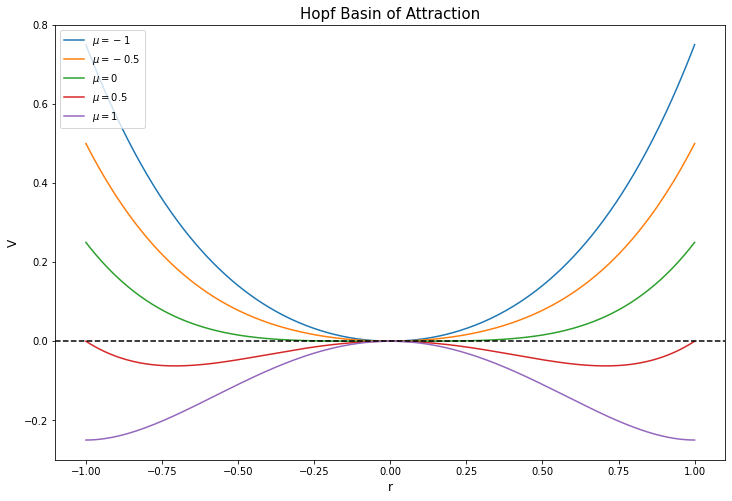

In [100]:
plt.figure(figsize=(12,8))
r = np.linspace(-1, 1, 500)
mu = -1
plt.plot(r, hopf_potential(mu,r), label='$\mu = {}$'.format(mu))
mu = -0.5
plt.plot(r, hopf_potential(mu, r), label='$\mu = {}$'.format(mu))
mu = 0
plt.plot(r, hopf_potential(mu, r), label='$\mu = {}$'.format(mu))
mu = 0.5
plt.plot(r, hopf_potential(mu, r), label='$\mu = {}$'.format(mu))
mu = 1
plt.plot(r, hopf_potential(mu, r), label='$\mu = {}$'.format(mu))
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Hopf Basin of Attraction', fontsize=15)
plt.xlabel('r', fontsize=12)
plt.ylabel('V', fontsize=12)
plt.legend(loc='upper left')
plt.show()


Note that $r$ is radius so in actuality, we really only consider $r \geq 0$

- We can see that for $\mu < 0$, there is a potential with a minimum at $r = 0$. Any noisy deviations from the minimum will be quickly restored back to $r=0$ as a result of the steep gradient on either side of the potential. In terms of the corresponding time-series, this results in low auto-correlation due to fast dynamics (next point is less like the previous). 
- As we increase $\mu$ towards 0 (the critical point), the potential becomes flatter around the minimum and so noisy deviations are more slowly restored to the origin (slower dynamics). This results in higher auto-correlation as the previous time pt. is more like the next. This is the concept of `critical slowing down` - as we approach the critical point, the time scales of the dynamics become much longer.
- For $\mu > 0$, the potential inverts and $r=0$ becomes unstable (local maximum). The minimum shifts to increasingly positive $r$ as $\mu$ continues to increase.

## Critical Slowing Down
To show the effect of critical slowing down on the scale of the dynamics, will plot the autocorrelation function at different distances from the critical point and compare. We expect to find the autocorrelation in increase as we approach the critical point at $\mu = 0$.

In [224]:
random.seed(454)
noise = 0.001
dt = 0.01
ic = np.array([0.3])
mus = [-10, -5, -2, -1, -0.5, -0.1]
tspan = np.arange(0, 1000, dt)
sols = list()
for mu in mus:
    def f(state, t):
        r = state
        drdt = mu * r - r**3
        return drdt 
    gw = lambda y, t: noise * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sol = sol[int(500/dt):]
    sols.append(sol)
tspan = tspan[int(500/dt):]


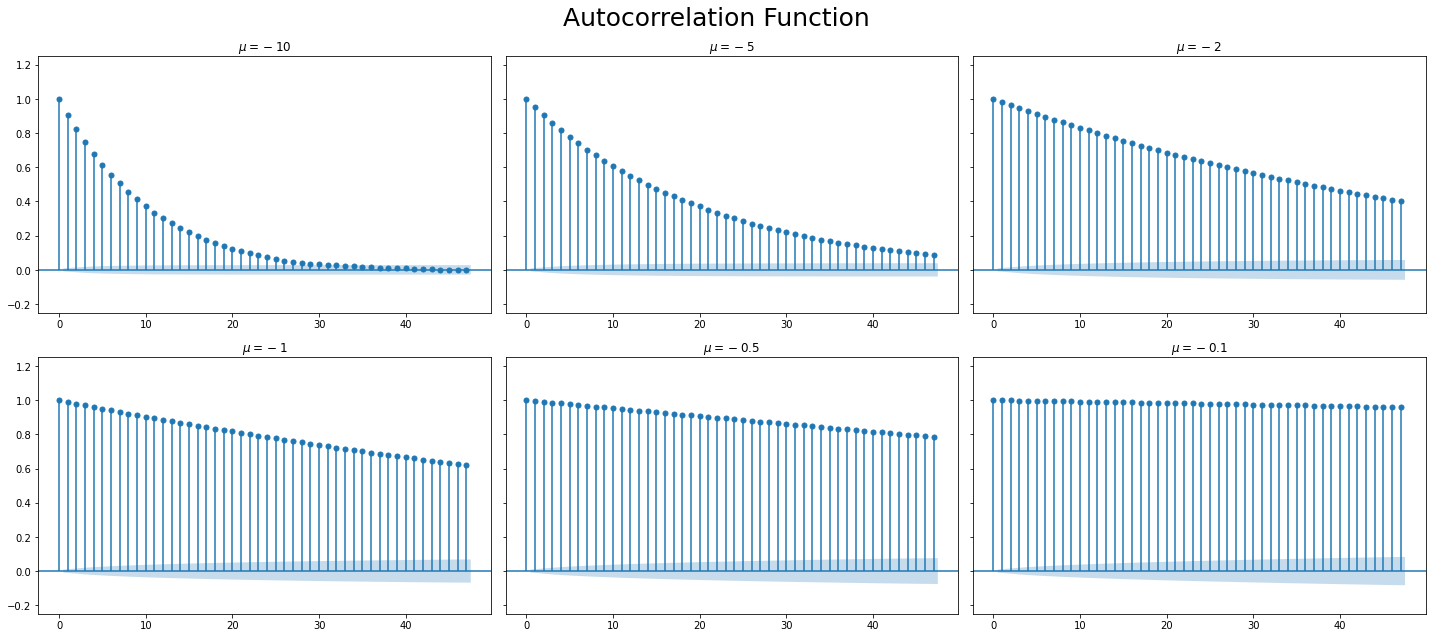

In [233]:
fig, ax = plt.subplots(2,3,figsize=(20,9), sharey=True)
plt.suptitle('Autocorrelation Function', fontsize=25)
sm.graphics.tsa.plot_acf(sols[0], ax=ax[0,0])
ax[0,0].set_title('$\mu = -10$')
ax[0,0].set_ylim(-0.25, 1.25)
sm.graphics.tsa.plot_acf(sols[1], ax=ax[0,1])
ax[0,1].set_title('$\mu = -5$')
ax[0,1].set_ylim(-0.25, 1.25)
sm.graphics.tsa.plot_acf(sols[2], ax=ax[0,2])
ax[0,2].set_title('$\mu = -2$')
ax[0,2].set_ylim(-0.25, 1.25)
sm.graphics.tsa.plot_acf(sols[3], ax=ax[1,0])
ax[1,0].set_title('$\mu = -1$')
ax[1,0].set_ylim(-0.25, 1.25)
sm.graphics.tsa.plot_acf(sols[4], ax=ax[1,1])
ax[1,1].set_title('$\mu = -0.5$')
ax[1,1].set_ylim(-0.25, 1.25)
sm.graphics.tsa.plot_acf(sols[5], ax=ax[1,2])
ax[1,2].set_title('$\mu = -0.1$')
ax[1,2].set_ylim(-0.25, 1.25)
plt.tight_layout()
plt.show()

As expected, the autocorrelation drops off more slowly as we approach the critical point (critical slowing down), a key indicator of dynamics on slower timescales as stochastic perturbations are returned to the minimum more slowly and thus the previous state is more like the next. 

# Fixed Points

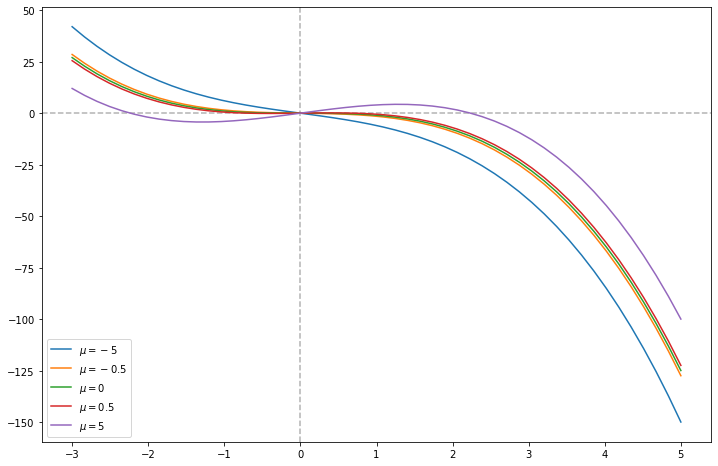

In [513]:
plt.figure(figsize=(12,8))
r = np.linspace(-3, 5)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
mu = -5
plt.plot(r, mu*r-r**3, label='$\mu = {}$'.format(mu))
mu = -0.5
plt.plot(r, mu*r-r**3, label='$\mu = {}$'.format(mu))
mu = 0
plt.plot(r, mu*r-r**3, label='$\mu = {}$'.format(mu))
mu = 0.5
plt.plot(r, mu*r-r**3, label='$\mu = {}$'.format(mu))
mu = 5
plt.plot(r, mu*r-r**3, label='$\mu = {}$'.format(mu))
plt.legend(loc = 'lower left')
plt.show()

For $\mu < 0$ the origin $r=0$ is a stable fixed point (stable spiral). For $\mu = 0$, the origin is still a stable spiral, though a very weak one -> the decay is extremely slow. For $\mu > 0$, there is an unstable spiral at the origin and a stable limit cycle at a positive value of $r$ that increases with $\mu$

## Selecting Regimes for Time Series Generation

Ran time-series generation on google colab - load in time-series. 

#### Lets just look at certain values of $\mu$ as opposed to a whole continuum so that it is a little more clear:
- 5 values of mu
- 10 noise levels $\eta$
- 20 instances per noise level, with random initial conditions
- CARTESIAN HOPF BIFURCATION

In [452]:
mus = [-5, -0.5, 0, 0.5, 5]
etas = np.linspace(0.01, 1, 10)
dt = 0.01
tspan = np.arange(0, 1000, dt)
n_samples = 20

In [ ]:
np.random.seed(0)
sols_list = list()
for mu in mus:
    for noise in etas:
        def f(state, t):
            r = state
            drdt = mu * r - r**3
            return drdt 
        for i in range(n_samples):
            ic = np.array([np.random.uniform(0, 1)])
            gw = lambda y, t: noise * np.identity(ic.shape[0]) # noise is relative to ic's 
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            eta = int(500/dt) # remove transients
            sol = sol[eta:]
            sols_list.append(sol)
        

In [564]:
with open('hopf_TS_XY.pkl', 'rb') as f:
    sols_list = pickle.load(f)

In [566]:
TS = [tspan, np.array([sols_list[i][:,0] for i in range(len(sols_list))])]
FEATURES = np.array([catch22.catch22_all(TS[1][i,:])['values'] for i in range(len(sols_list))])

In [569]:
normalized_features = StandardScaler().fit_transform(FEATURES)
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(normalized_features)

In [570]:
mus_plot = np.concatenate([np.tile(mus[i], 200) for i in range(5)])
etas_plot = np.tile(np.concatenate([np.tile(etas[i], 20) for i in range(10)]), 5)

In [571]:
def label_region(row):
    if row['mu'] == -5:
        return 'FLHB' # CP is critical point/Hopf Bifurcation
    if row['mu'] == -0.5:
        return 'CLHB' 
    if row['mu'] == 0:
        return 'HB' # Fixed point upper branch
    if row['mu'] == 0.5:
        return 'CRHB' 
    if row['mu'] == 5:
        return 'FRHB' 

In [572]:
df = pd.DataFrame(embedding)
df['mu'] = mus_plot
df['eta'] = etas_plot
df['regime'] = df.apply(lambda row: label_region(row), axis=1)

In [610]:
fig = px.scatter(df, x=0, y=1, color=df['regime'],
    labels={'0': 'PC1', '1': 'PC2', 'color': r"$\lambda$"}, width=1200, height=800, custom_data=['mu', 'eta', 'regime'])
fig.update_traces(
    hovertemplate="<br>".join([
        "Mu: %{customdata[0]:.3f}",
        "Eta: %{customdata[1]:.3f}",
        "Regime: %{customdata[2]}"
    ])
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title_text='Catch22 Instance Space, Hopf Bifurcation (Cartesian)', title_x=0.5)
fig.show()

In [611]:
def plot_ts(ts_index):
    plt.figure(figsize=(20,6))
    sol = TS[1][ts_index, ]
    plt.plot(tspan[eta:], sol)
    mu_val = df.iloc[ts_index]['mu']
    eta_val = df.iloc[ts_index]['eta']
    plt.title(f'$\mu = {mu_val}$, $\eta = {eta_val}$')
    plt.xlim(left = 500, right=1000)
    plt.ylim(-5, 5)
ipywidgets.interact(plot_ts, ts_index=IntSlider(0, 0,999, 1, layout=Layout(width='1000px')))
plt.show()

interactive(children=(IntSlider(value=0, description='ts_index', layout=Layout(width='1000px'), max=999), Outp…